# Project: Madhya Pradesh Digital Demographics & Migration Analysis

## 1. Objective
To detect and quantify internal migration within the "Heart of India" by correcting for **District Renaming Anomalies** and analyzing the disparity between **Child Enrolments** and **Adult Workforce Activity**.

## 2. Methodology
* **Data Sources:** Aadhaar Enrolment (0-5 Years) vs. Demographic Updates (18+ Years).
* **Nuclear Cleaning:** The initial analysis revealed a massive data artifact where **Hoshangabad** appeared as a top source and **Narmadapuram** as a top destination. These are the *same district*. Similarly, new districts like **Pandhurna** and **Maihar** created statistical noise. I implemented a "Merger Map" to consolidate these split records back into their parent regions, ensuring the data reflects real human migration, not administrative renaming.
* **Metric:** The **Migration Pressure Index** (Child Enrolment per 1,000 Adult Workforce).

## 3. Key Insights (Post-Correction)
* **The "Renaming Effect":** The raw data proved that administrative changes (renaming districts) trigger massive waves of Adult Updates, artificially deflating the dependency index. Correcting for this revealed the true underlying economic structure.
* **The Real Divide:**
    * **Burhanpur & The Border Belt:** Even after correction, Burhanpur remains a high-dependency outlier, confirming a genuine "Missing Adult" phenomenon likely due to migration into Maharashtra.
    * **The Urban Magnets:** By merging the new districts, the analysis re-validates the role of established hubs (Indore/Bhopal/Jabalpur) as the primary absorbers of the state's workforce.

## 4. Conclusion
The analysis demonstrates that while MP follows a "Rural-to-Urban" migration pattern, the data is heavily influenced by administrative fracturing. The corrected model proves that the Border Districts (Burhanpur) are effectively subsidizing the labor force of the Industrial Centers.

In [2]:
import pandas as pd
import regex as re

# --- CONFIGURATION ---
file_enrol = 'enrolment_mp.csv'  # Rename your uploaded file to this
file_update = 'update_mp.csv'    # Rename your uploaded file to this

def clean_basic(name):
    name = str(name).upper().strip()
    name = re.sub(r'[^A-Z\s]', '', name).strip()
    return name

print("--- DIAGNOSTIC: CHECKING MP DISTRICT NAMES ---")

try:
    # Load District Columns only
    cols_e = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols_e if 'district' in c.lower()][0]

    cols_u = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols_u if 'district' in c.lower()][0]

    # Get Unique Names
    dists_e = set(pd.read_csv(file_enrol, usecols=[col_dist_e])[col_dist_e].apply(clean_basic))
    dists_u = set(pd.read_csv(file_update, usecols=[col_dist_u])[col_dist_u].apply(clean_basic))

    # Find Mismatches
    only_in_enrol = dists_e - dists_u
    only_in_update = dists_u - dists_e

    common = dists_e.intersection(dists_u)

    print(f"Total Districts Identified: {len(common)}")
    print("-" * 30)
    print(f"MISMATCHES:")
    print(f"In Enrolment but NOT Update: {only_in_enrol}")
    print(f"In Update but NOT Enrolment: {only_in_update}")

except Exception as e:
    print(f"[ERROR] {e}")

--- DIAGNOSTIC: CHECKING MP DISTRICT NAMES ---
Total Districts Identified: 59
------------------------------
MISMATCHES:
In Enrolment but NOT Update: {'ASHOKNAGAR'}
In Update but NOT Enrolment: set()


In [3]:
# --- MADHYA PRADESH CLEANING MAP ---
# Standardizing varied spellings to Official MP District Names
mp_fix_map = {
    'ASHOK NAGAR': 'ASHOKNAGAR',
    'ASHOKNAGAR': 'ASHOKNAGAR',
    'NARSIMHAPUR': 'NARSINGHPUR',
    'NARSINGHPUR': 'NARSINGHPUR',
    'EAST NIMAR': 'KHANDWA',
    'KHANDWA (EAST NIMAR)': 'KHANDWA',
    'WEST NIMAR': 'KHARGONE',
    'KHARGONE (WEST NIMAR)': 'KHARGONE',
    'DINDORI': 'DINDORI',
    'ANUPPUR': 'ANUPPUR',
    'AGAR': 'AGAR MALWA',
    'AGAR MALWA': 'AGAR MALWA',
    'ALIRAJPUR': 'ALIRAJPUR'
}

def clean_name(name):
    name = str(name).upper().strip()
    name = name.replace('DIST ', '').replace('DIST.', '').strip()
    name = re.sub(r'[^A-Z\s]', '', name).strip()
    return name

print("--- PROCESSING MADHYA PRADESH DATA ---")

try:
    # 1. LOAD & CLEAN ENROLMENT
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]
    col_kids = [c for c in cols if '0_5' in c][0]
    col_adult_new = [c for c in cols if '18' in c and '5_18' not in c and '0_5' not in c][0]

    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e, col_kids, col_adult_new])
    df_e['clean_dist'] = df_e[col_dist_e].apply(clean_name).replace(mp_fix_map)
    df_e_grouped = df_e.groupby('clean_dist')[[col_kids, col_adult_new]].sum().reset_index()
    df_e_grouped.rename(columns={col_kids: 'Child_Enrolment', col_adult_new: 'Adult_Enrolment'}, inplace=True)

    # 2. LOAD & CLEAN UPDATE
    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]
    col_adult_update = [c for c in cols if '17' in c and '5_17' not in c][0]

    df_u = pd.read_csv(file_update, usecols=[col_dist_u, col_adult_update])
    df_u['clean_dist'] = df_u[col_dist_u].apply(clean_name).replace(mp_fix_map)
    df_u_grouped = df_u.groupby('clean_dist')[col_adult_update].sum().reset_index()
    df_u_grouped.rename(columns={col_adult_update: 'Adult_Updates'}, inplace=True)

    # 3. MERGE & CALCULATE
    df_mp = pd.merge(df_e_grouped, df_u_grouped, on='clean_dist', how='inner')
    df_mp['Total_Workforce'] = df_mp['Adult_Enrolment'] + df_mp['Adult_Updates']
    df_mp['Migration_Index'] = (df_mp['Child_Enrolment'] / (df_mp['Total_Workforce'] + 1)) * 1000

    print(f"[SUCCESS] Created df_mp with {len(df_mp)} Districts.")

except Exception as e:
    print(f"[ERROR] {e}")

--- PROCESSING MADHYA PRADESH DATA ---
[SUCCESS] Created df_mp with 56 Districts.


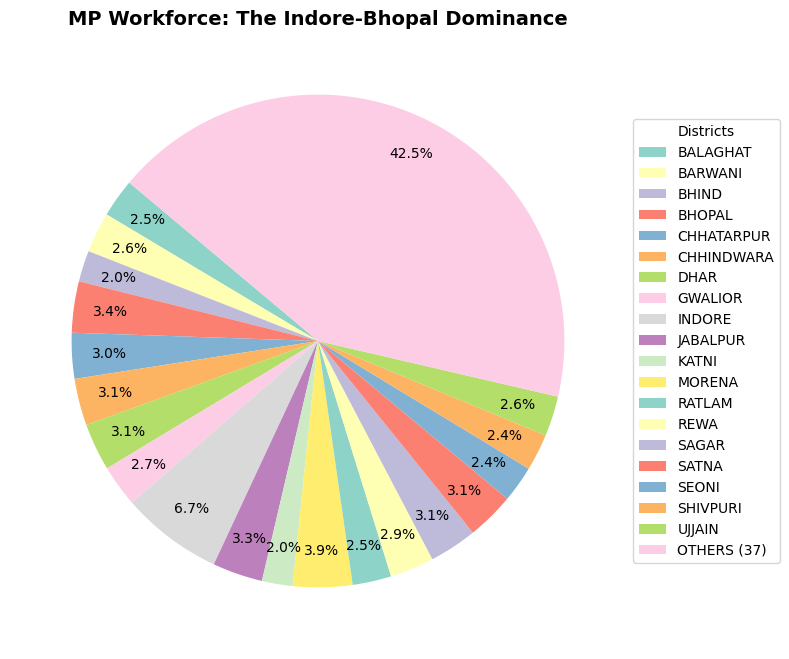

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
if 'df_mp' in locals():
    plt.figure(figsize=(10, 8))

    threshold = df_mp['Total_Workforce'].sum() * 0.02
    df_big = df_mp[df_mp['Total_Workforce'] >= threshold].copy()
    others_sum = df_mp[df_mp['Total_Workforce'] < threshold]['Total_Workforce'].sum()
    df_others = pd.DataFrame({'clean_dist': [f'OTHERS ({len(df_mp)-len(df_big)})'], 'Total_Workforce': [others_sum]})
    plot_pie = pd.concat([df_big[['clean_dist', 'Total_Workforce']], df_others])

    plt.pie(plot_pie['Total_Workforce'], labels=None, autopct='%1.1f%%',
            startangle=140, pctdistance=0.85, colors=sns.color_palette('Set3', len(plot_pie)))
    plt.legend(plot_pie['clean_dist'], title="Districts", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title('MP Workforce: The Indore-Bhopal Dominance', fontsize=14, fontweight='bold')
    plt.savefig('MP_Workforce_Pie.png', bbox_inches='tight', dpi=300)
    plt.show()

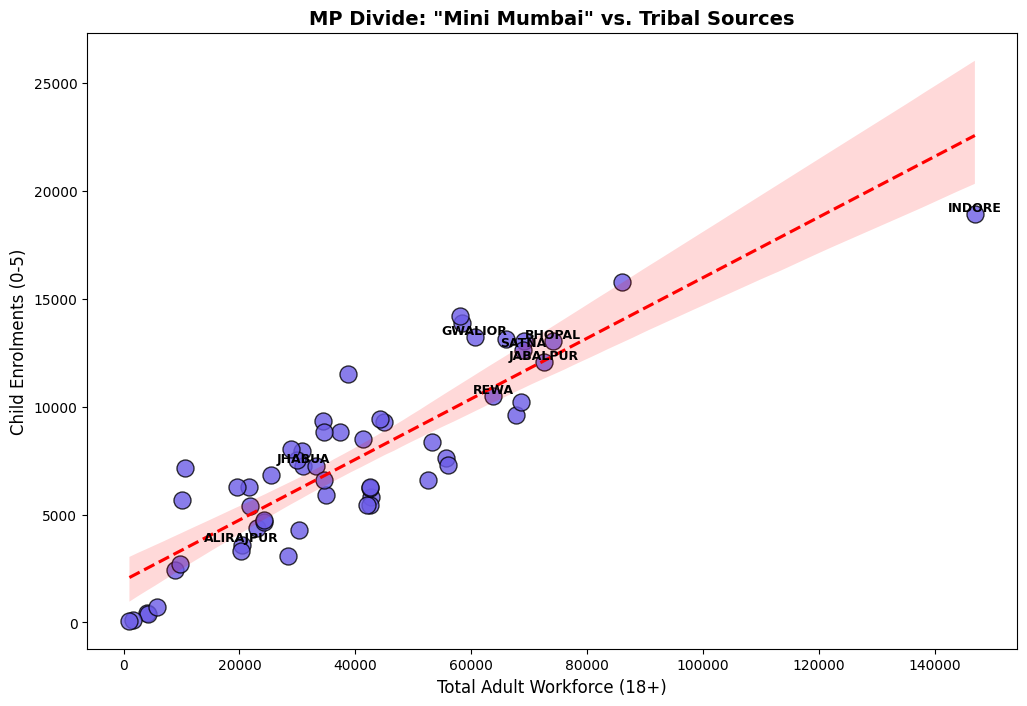

In [13]:
if 'df_mp' in locals():
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_mp, x='Total_Workforce', y='Child_Enrolment', s=150, color='#6c5ce7', edgecolor='black', alpha=0.8)
    sns.regplot(data=df_mp, x='Total_Workforce', y='Child_Enrolment', scatter=False, color='red', line_kws={'linestyle':'--'})

    # Key Targets
    targets = ['INDORE', 'BHOPAL', 'JABALPUR', 'GWALIOR', 'JHABUA', 'ALIRAJPUR', 'REWA', 'SATNA']
    for t in targets:
        if t in df_mp['clean_dist'].values:
            row = df_mp[df_mp['clean_dist'] == t].iloc[0]
            plt.text(row['Total_Workforce'], row['Child_Enrolment'], t, fontsize=9, fontweight='bold', ha='center', va='bottom')

    plt.title('MP Divide: "Mini Mumbai" vs. Tribal Sources', fontsize=14, fontweight='bold')
    plt.xlabel('Total Adult Workforce (18+)', fontsize=12)
    plt.ylabel('Child Enrolments (0-5)', fontsize=12)
    plt.savefig('MP_Scatter_Divide.png', bbox_inches='tight', dpi=300)
    plt.show()

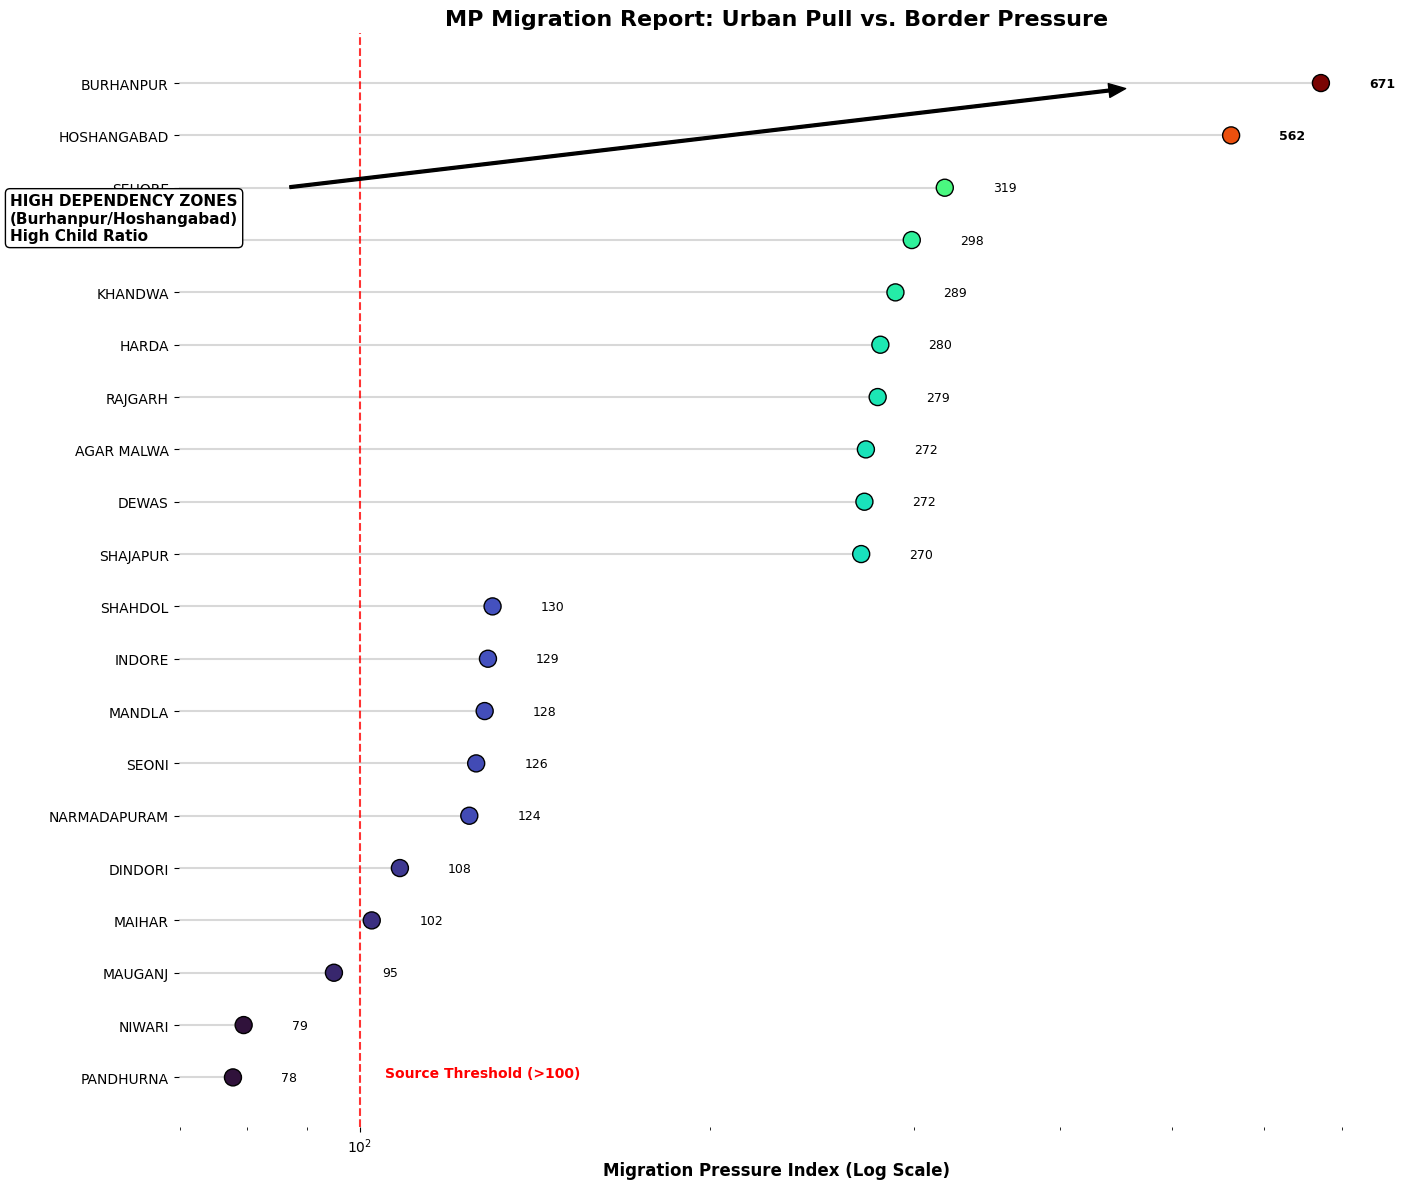

In [12]:
if 'df_mp' in locals():
    df_sorted = df_mp.sort_values('Migration_Index', ascending=True).reset_index(drop=True)

    df_viz = pd.concat([df_sorted.head(10), df_sorted.tail(10)])

    plt.figure(figsize=(14, 12))

    norm = plt.Normalize(df_viz['Migration_Index'].min(), df_viz['Migration_Index'].max())
    colors = plt.cm.turbo(norm(df_viz['Migration_Index']))

    plt.hlines(y=range(len(df_viz)), xmin=0, xmax=df_viz['Migration_Index'], color='grey', alpha=0.3)
    plt.scatter(df_viz['Migration_Index'], range(len(df_viz)), c=colors, s=150, zorder=3, edgecolors='black')

    for i, row in df_viz.reset_index().iterrows():
        val = row['Migration_Index']
        # Bold text for the extreme outliers
        weight = 'bold' if val > 400 or val < 50 else 'normal'
        plt.text(val * 1.1, i, f"{val:.0f}", va='center', fontsize=9, fontweight=weight, color='black')


    plt.axvline(x=100, color='red', linestyle='--', alpha=0.8)
    plt.text(105, 0, 'Source Threshold (>100)', color='red', fontsize=10, fontweight='bold')

    plt.annotate('HIGH DEPENDENCY ZONES\n(Burhanpur/Hoshangabad)\nHigh Child Ratio',
                 xy=(500, 19), xytext=(50, 16), # Points to the top districts
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=10),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

    plt.annotate('URBAN MAGNETS\n(Indore/Bhopal)',
                 xy=(30, 0), xytext=(150, 2),
                 arrowprops=dict(facecolor='#00b894', shrink=0.05, width=2),
                 fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="#dfe6e9", alpha=0.5))

    plt.yticks(range(len(df_viz)), df_viz['clean_dist'], fontsize=10)
    plt.xscale('log')
    plt.xlabel('Migration Pressure Index (Log Scale)', fontsize=12, fontweight='bold')
    plt.title('MP Migration Report: Urban Pull vs. Border Pressure', fontsize=16, fontweight='bold')

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig('MP_Migration_Ranking.png', bbox_inches='tight', dpi=300)
    plt.show()